## Installing and importing libraries

In [ ]:
# first we have to install some libraries in Colab
!pip install zarr
!pip install gcsfs

# and set up Cartopy
!pip uninstall shapely --yes

# note: the next step produces an error in pip. You can ignore this error.
!pip install lida==0.0.10 shapely cartopy --no-binary shapely --no-binary cartopy --use-deprecated=legacy-resolver

# and manually download shape files for Cartopy
!wget https://raw.githubusercontent.com/SciTools/cartopy/main/lib/cartopy/feature/download/__main__.py -O cartopy_feature_download.py
!python cartopy_feature_download.py physical

Found existing installation: shapely 2.0.2
Uninstalling shapely-2.0.2:
  Successfully uninstalled shapely-2.0.2
Processing /root/.cache/pip/wheels/1f/6b/52/14cb4558cddc0fd89de08f0e1fd08f816f4f3e1969311377c6/shapely-2.0.2-cp310-cp310-linux_x86_64.whl


--2024-01-24 15:26:42--  https://raw.githubusercontent.com/SciTools/cartopy/main/lib/cartopy/feature/download/__main__.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6357 (6.2K) [text/plain]
Saving to: ‘cartopy_feature_download.py’

cartopy_feature_dow 100%[===================>]   6.21K  --.-KB/s    in 0s      

2024-01-24 15:26:42 (52.3 MB/s) - ‘cartopy_feature_download.py’ saved [6357/6357]

Feature physical, coastline, 110m length: 134
Feature physical, coastline, 50m length: 1428
Feature physical, coastline, 10m length: 4133
Feature physical, land, 110m length: 127
Feature physical, land, 50m length: 1420
Feature physical, land, 10m length: 11
Feature physical, ocean, 110m length: 2
Feature physical, ocean, 50m length: 1
Feature physical, ocean, 10m 

In [ ]:
# set up our libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

# set up cartopy
import cartopy.crs as ccrs
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

# notebook display options
xr.set_options(display_style='html')
%matplotlib inline

## Extract the data from the catalog

Here we filter the data to find monthly sea surface concentration.

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_ta = df.query("table_id == 'SImon' & variable_id == 'siconc' & grid_label == 'gn'")
df_ta

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
597,CFMIP,IPSL,IPSL-CM6A-LR,abrupt-2xCO2,r1i1p1f1,SImon,siconc,gn,gs://cmip6/CMIP6/CFMIP/IPSL/IPSL-CM6A-LR/abrup...,NaN,20180605
772,CMIP,CNRM-CERFACS,CNRM-CM6-1,1pctCO2,r1i1p1f2,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180626
966,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
978,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r2i1p1f1,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
1300,CMIP,NOAA-GFDL,GFDL-ESM4,esm-hist,r1i1p1f1,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/esm-...,NaN,20180701
...,...,...,...,...,...,...,...,...,...,...,...
523554,CMIP,MRI,MRI-ESM2-0,historical,r7i1p1f1,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20210909
523555,CMIP,MRI,MRI-ESM2-0,historical,r8i1p1f1,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20210909
523559,CMIP,MRI,MRI-ESM2-0,historical,r9i1p1f1,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20210909
523561,CMIP,MRI,MRI-ESM2-0,historical,r10i1p1f1,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20210909


Here we choose a model GFDL-ESM4 produced by NOAA-GFDL and we also choose a scenario ssp585, which is considered to be one of the closest to what will probably happen

In [ ]:
df_ta = df.query("institution_id == 'NOAA-GFDL' & experiment_id == 'ssp585' & source_id == 'GFDL-ESM4' &  table_id == 'SImon' & variable_id == 'siconc' & grid_label == 'gn'")

## Load data

Now we will load a single store using gcsfs, zarr, and xarray.

In [ ]:
def load_data(df) :
  # setup the gcs access
  gcs = gcsfs.GCSFileSystem(token='anon')

  # get the path to a specific zarr store (the last one from the dataframe above)
  zstore = df.zstore.values[-1]

  # create a mapping interface to the store
  mapper = gcs.get_mapper(zstore)

  # open it using xarray and zarr
  ds = xr.open_zarr(mapper, consolidated=True,decode_times=False)

  # convert time from int to datetime format
  ds['time'] = pd.to_datetime(ds['time'], origin='2015-01-16 12:00:00.000000', unit='h')
  return ds

In [ ]:
ds = load_data(df_ta)

# restrict the data to the central Arctic region, north of 70°N
lat = ds['lat'].compute()
ds=ds.where(lat > 70,drop=True)

ds

/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1449: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


<xarray.Dataset>
Dimensions:    (y: 95, x: 612, time: 1032, bnds: 2, vertex: 4, xTe: 721,
                yTe: 577)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    lat        (y, x) float32 66.18 66.22 66.27 66.31 ... 70.67 70.5 70.33 70.15
    lat_bnds   (y, x, vertex) float32 dask.array<chunksize=(95, 612, 4), meta=np.ndarray>
    lon        (y, x) float32 -286.6 -286.1 -285.6 -285.1 ... 59.88 59.88 59.88
    lon_bnds   (y, x, vertex) float32 dask.array<chunksize=(95, 612, 4), meta=np.ndarray>
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-11-25T12:00:00
    time_bnds  (time, bnds) float64 dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * x          (x) float64 -286.2 -285.8 -285.2 -284.8 ... 45.25 45.75 46.25
  * xTe        (xTe) float64 -300.0 -299.5 -299.0 -298.5 ... 58.5 59.0 59.5 60.0
  * y          (y) float64 70.04 70.25 70.46 70.68 ... 89.26 89.47 89.68 89.89
  * yTe        (yTe) float64 -78.0 -77.82 -77.63 -77.45 ... 89.58 89.79 90.0
Dimensions without coordinates: vertex
Data variables:
    GEOLAT     (y, x) float32 dask.array<chunksize=(95, 612), meta=np.ndarray>
    GEOLON     (y, x) float32 dask.array<chunksize=(95, 612), meta=np.ndarray>
    siconc     (time, y, x) float32 dask.array<chunksize=(600, 95, 612), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0
    comment:                <null ref>
    ...                     ...
    variable_id:            siconc
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/98c994eb-4bd1-437c-8a2e-ba711a659f71
    version_id:             v20180701

## Plot a map from a specific date.

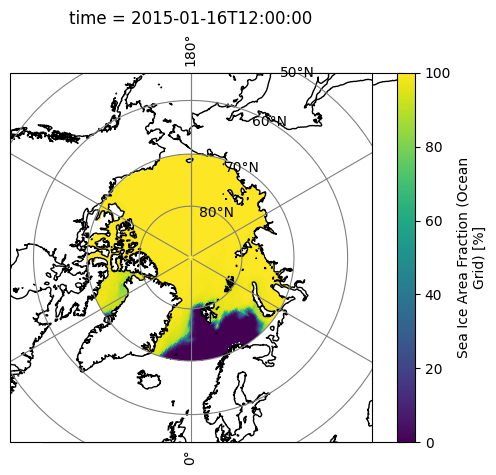

In [ ]:
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
ax.coastlines()

# first we set up our axes with the projection that we want
ax = plt.axes(projection=ccrs.NorthPolarStereo());
# then we set the latitude limits on our figure (here, we include all longitudes
# (-180° -> 180°) and 55°N -> 90°N)
ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
# now we tell xarray to plot our data. We pass a number of extra parameters:
# transform=ccrs.PlateCarree() -> tells xarray how to transform the data
# x='lon' -> tells xarray the name of the longitude variable
# y='lat' -> tells xarray the name of the latitude variable
ds.siconc[0].plot.pcolormesh(ax=ax,transform=ccrs.PlateCarree(),x='lon', y='lat', add_colorbar=True);
# finally, we add the coastlines
ax.coastlines();
# and add grid lines
ax.gridlines(draw_labels=True, x_inline=False, y_inline=True,color='grey');

## Expectation of the evolution of sea ice area with 2 differents scenarios

*Dataset optimistic Experiment ssp245*

In [ ]:
df_opt = df.query("activity_id=='ScenarioMIP' & table_id == 'SImon' & variable_id == 'siconc' & experiment_id == 'ssp245' & institution_id == 'IPSL'")
ds_opt = load_data(df_opt)

lat = ds_opt['nav_lat'].compute()
ds_opt = ds_opt.where(lat > 70, drop=True)

*Dataset pessimistic Experiment ssp585*

In [ ]:
df_pes = df.query("activity_id=='ScenarioMIP' & table_id == 'SImon' & variable_id == 'siconc' & experiment_id == 'ssp585' & institution_id == 'IPSL'")
ds_pes = load_data(df_pes)

lat = ds_pes['nav_lat'].compute()
ds_pes = ds_pes.where(lat > 70, drop=True)

Make the seasonal average

In [ ]:
ds_opt = ds_opt.resample(time='QS-DEC').mean(dim="time")
ds_pes = ds_pes.resample(time='QS-DEC').mean(dim="time")

In [ ]:
# we can select the winter data using where
winter_opt = ds_opt.where(ds_opt.time.dt.season == 'DJF',drop=True)
winter_pes = ds_pes.where(ds_pes.time.dt.season == 'DJF',drop=True)
# the other seasons are called 'MAM', 'JJA', 'SON', and we can
# select them the same way

# another way to do the same thing is by taking every 4th element
# along the time dimension, like this:
# winter = ds_sic.isel(time=np.arange(0,ds_sic.time.size,4))

/usr/local/lib/python3.10/dist-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/usr/local/lib/python3.10/dist-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


Plot the time series at one of the points

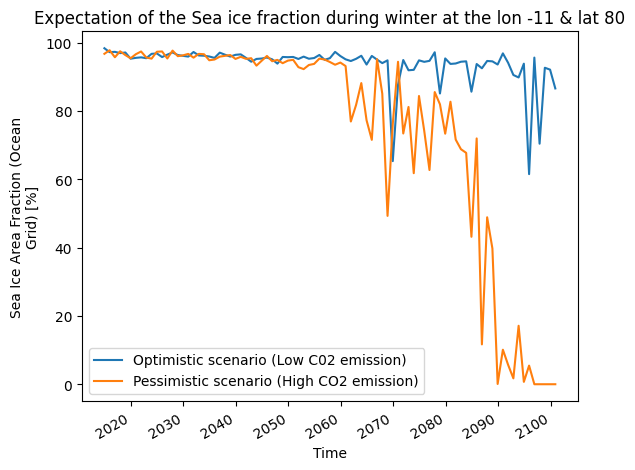

In [ ]:
winter_opt.isel(x=150,y=20).siconc.plot(label="Optimistic scenario (Low C02 emission)")
winter_pes.isel(x=150,y=20).siconc.plot(label="Pessimistic scenario (High CO2 emission)")
plt.xlabel("Time")
plt.title("Expectation of the Sea ice fraction during winter at the lon -11 & lat 80")
plt.legend()
plt.show()

In [ ]:
winter_opt_5y = winter_opt.resample(time='5y').mean()
winter_pes_5y = winter_pes.resample(time='5y').mean()

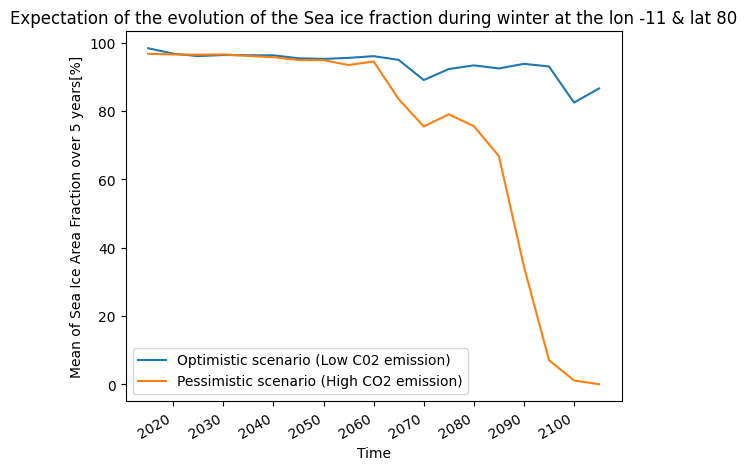

In [ ]:
# we now have only 19 points in the time dimension. Let's look at the time series
# at the same point as before to compare the form:
winter_opt_5y.isel(x=150,y=20).siconc.plot(label="Optimistic scenario (Low C02 emission)")
winter_pes_5y.isel(x=150,y=20).siconc.plot(label="Pessimistic scenario (High CO2 emission)")
plt.xlabel("Time")
plt.ylabel("Mean of Sea Ice Area Fraction over 5 years[%]")
plt.title("Expectation of the evolution of the Sea ice fraction during winter at the lon -11 & lat 80")
plt.legend()
plt.show()

## Clustering the time series of sea ice concentration to identify coherent regions of sea ice loss.

Import libraries

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
df_pes = df.query("activity_id=='ScenarioMIP' & table_id == 'SImon' & variable_id == 'siconc' & experiment_id == 'ssp585' & institution_id == 'IPSL' & grid_label =='gn' & member_id =='r1i1p1f1'")
df_opt = df.query("activity_id=='ScenarioMIP' & table_id == 'SImon' & variable_id == 'siconc' & experiment_id == 'ssp245' & institution_id == 'IPSL' & grid_label =='gn' & member_id =='r1i1p1f1'")
df_opt_model = df.query("activity_id=='ScenarioMIP' & table_id == 'SImon' & variable_id == 'siconc' & experiment_id == 'ssp245' & institution_id == 'NOAA-GFDL' & source_id == 'GFDL-ESM4' & grid_label =='gn' & member_id =='r1i1p1f1'")
df_opt_model


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
15225,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp245,r1i1p1f1,SImon,siconc,gn,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701


Function to convert the DataArrray into a Numpy table and get the classification of each pixel in a cluster with the Kmeans algorithm.

In [ ]:
# Convert the DataArray into a Numpy table
def get_data(df,year):
  "Enter a year from 0 (for 2015) to 85 (for 2100)"
  ds = load_data(df)
  try :
    lat = ds['lat'].compute()
    lon = ds['lon'].compute()
  except :
    lat = ds['nav_lat'].compute()
    lon = ds['nav_lon'].compute()

  ds = ds.where(lat > 70, drop=True)

  # Get the data for only 1 year
  ds_1y = ds.siconc[year*12:(year+1)*12]

  ds_1y_stacked = ds_1y.stack(pixel=('y', 'x'))
  # Supprimer les valeurs NaN de l'ensemble de données
  ds_1y_cleaned = ds_1y_stacked.dropna(dim='pixel')
  # Convertissez le DataArray en un tableau NumPy
  X = ds_1y_cleaned.T

  return X


# Classified each pixel with Kmeans algorithm
def data_kmeans(X,nb_clusters):
  # Create the classifier:
  kmeans = KMeans(n_clusters=nb_clusters, random_state=0, n_init=10)

  # Train the classifier:
  kmeans.fit(X)

  # Classify the dataset:
  labels = kmeans.predict(X)

  return labels


In [ ]:
def compting_cluster(df,kmeans):
  # Number of year to deal with
  nb_years = 17 #=85/5 (once every 5 years)
  # Optimal clustering with 3 clusters
  nb_cluster_opt = 3

  compteur = np.zeros((3,nb_years))


  for i in range(nb_years):
    # Get the data for 1 year
    ds = load_data(df)
    try :
      lat = ds['lat'].compute()
      lon = ds['lon'].compute()
    except :
      lat = ds['nav_lat'].compute()
      lon = ds['nav_lon'].compute()

    ds = ds.where(lat > 70, drop=True)
    data = ds.siconc[5*12*i:5*12*i+12]

    # Get the data in the good format
    data_stacked = data.stack(pixel=('y', 'x'))
    # Supprimer les valeurs NaN de l'ensemble de données
    data_cleaned = data_stacked.dropna(dim='pixel')
    # Convertissez le DataArray en un tableau NumPy
    X = data_cleaned.T

    # Apply clustering
    labels = kmeans.predict(X)

    comptage = np.bincount(labels)
    for k in range(nb_cluster_opt):
      compteur[k,i]=comptage[k]

    print(f'counting for the year {2015+5*i} done')

  return compteur

To choose the most fitting number of clusters for the classification we use the silhouette score.

In [ ]:
X = get_data(df_pes,0)
nb_clusters_max = 10
s = np.zeros(nb_clusters_max-2)
for k in range(2,nb_clusters_max):
  # Create the classifier:
  kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
  # Train the classifier:
  kmeans.fit(X)
  # Classify the dataset:
  labels = kmeans.predict(X)

  # Compute the silhouette score
  s[k-2] = silhouette_score(X, labels)

  print(f'number of clusters : {k}, silhouette score : {s[k-2]}')

number of clusters : 2, silhouette score : 0.49039897322654724
number of clusters : 3, silhouette score : 0.5626989603042603
number of clusters : 4, silhouette score : 0.5297717452049255
number of clusters : 5, silhouette score : 0.48475003242492676
number of clusters : 6, silhouette score : 0.4728946089744568
number of clusters : 7, silhouette score : 0.4762396812438965
number of clusters : 8, silhouette score : 0.47502654790878296
number of clusters : 9, silhouette score : 0.48617422580718994


Text(0.5, 1.0, 'Silhouette analysis for Kmeans clustering for various clusters on 2015 data')

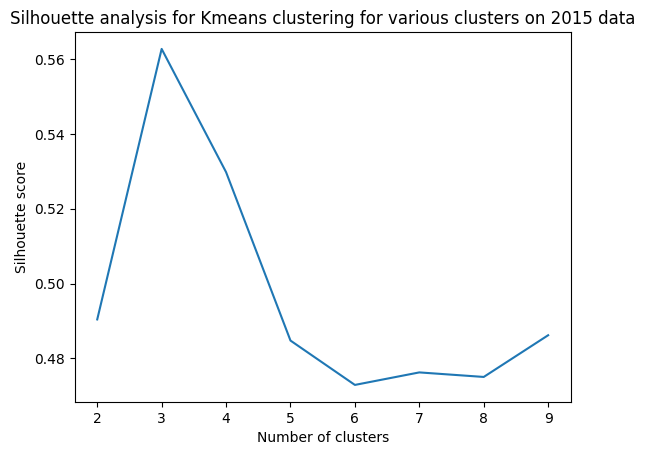

In [ ]:
plt.plot(np.arange(2,nb_clusters_max),s)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis for Kmeans clustering for various clusters on 2015 data')

## Scenarios comparison

Scénario pessimiste (ssp585) en 2015

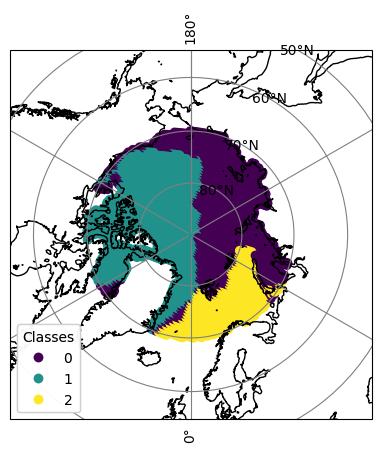

In [ ]:
# Get the data of the ssp585 scenario
X_pes = get_data(df_pes,0)
# Makes clusters
labels_pes = data_kmeans(X_pes,3)
# Plot
ax = plt.axes(projection=ccrs.NorthPolarStereo());
ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
scatter = ax.scatter(X_pes.nav_lon, X_pes.nav_lat, c=labels_pes, transform=ccrs.PlateCarree());
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
ax.coastlines();
ax.gridlines(draw_labels=True, x_inline=False, y_inline=True,color='grey');

Scenario optimiste (ssp245) en 2015

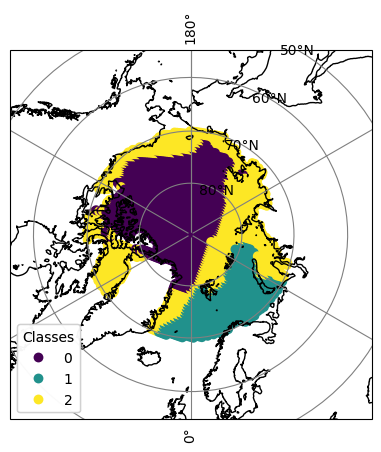

In [ ]:
# Get the data of the ssp585 scenario
X_opt = get_data(df_opt,0)
# Makes clusters
labels_opt = data_kmeans(X_opt,3)
# Plot
ax = plt.axes(projection=ccrs.NorthPolarStereo());
ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
scatter = ax.scatter(X_opt.nav_lon, X_opt.nav_lat, c=labels_opt, transform=ccrs.PlateCarree());
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
ax.coastlines();
ax.gridlines(draw_labels=True, x_inline=False, y_inline=True,color='grey');

## Year comparisons (between 2015 and 2100)

### For the pessimistic scenario (ssp585)




En 2015

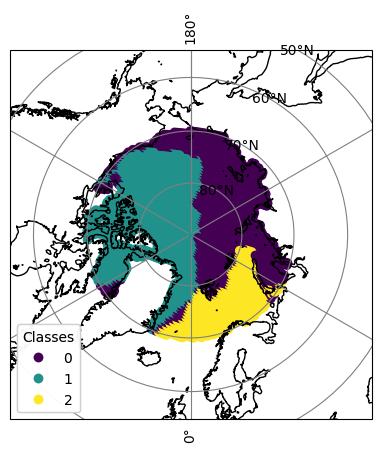

In [ ]:
# Get the data of the ssp585 scenario
X_pes_2015 = get_data(df_pes,0)

# Makes clusters
# Create the classifier:
kmeans_pes = KMeans(n_clusters=3, random_state=0, n_init=10)
# Train the classifier:
kmeans_pes.fit(X_pes_2015)
# Classify the dataset:
labels_pes_2015 = kmeans_pes.predict(X_pes_2015)

# Plot
ax = plt.axes(projection=ccrs.NorthPolarStereo());
ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
scatter = ax.scatter(X_pes_2015.nav_lon, X_pes_2015.nav_lat, c=labels_pes_2015, transform=ccrs.PlateCarree());
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
ax.coastlines();
ax.gridlines(draw_labels=True, x_inline=False, y_inline=True,color='grey');

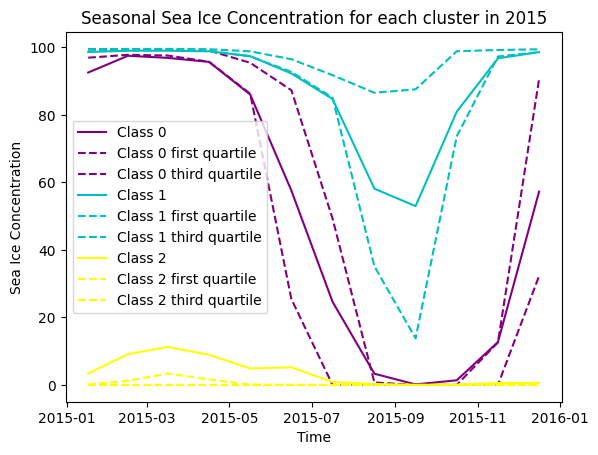

In [ ]:
# restrict the data to the central Arctic region, north of 70°N
X_pes_2015['classes'] = 'pixel', np.array(labels_pes_2015).reshape(X_pes_2015['pixel'].size)
X_pes_2015_mean = X_pes_2015.groupby('classes').mean(dim='pixel')

X_pes_2015_q1 = X_pes_2015.groupby('classes').quantile(q=0.25, dim='pixel')
X_pes_2015_q3 = X_pes_2015.groupby('classes').quantile(q=0.75, dim='pixel')

colors=['purple','c','yellow']
for label in X_pes_2015_mean['classes']:
  plt.plot(X_pes_2015_mean['time'], X_pes_2015_mean.sel(classes=label), label=f'Class {label.item()}', c=colors[label.item()])
  plt.plot(X_pes_2015_q1['time'], X_pes_2015_q1.sel(classes=label), label=f'Class {label.item()} first quartile', c=colors[label.item()], linestyle='--')
  plt.plot(X_pes_2015_q3['time'], X_pes_2015_q3.sel(classes=label), label=f'Class {label.item()} third quartile', c=colors[label.item()], linestyle='--')

plt.xlabel('Time')
plt.ylabel('Sea Ice Concentration')
plt.title('Seasonal Sea Ice Concentration for each cluster in 2015')
plt.legend()
plt.show()

En 2100 (prediction)

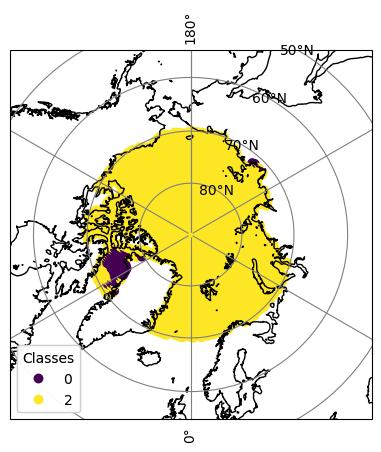

In [ ]:
# Get the data of the ssp585 scenario
X_pes_2100 = get_data(df_pes,85)
# Makes clusters
labels_pes_2100 = kmeans_pes.predict(X_pes_2100)
# Plot
ax = plt.axes(projection=ccrs.NorthPolarStereo());
ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
scatter = ax.scatter(X_pes_2100.nav_lon, X_pes_2100.nav_lat, c=labels_pes_2100, transform=ccrs.PlateCarree());
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
ax.coastlines();
ax.gridlines(draw_labels=True, x_inline=False, y_inline=True,color='grey');

In [ ]:
# restrict the data to the central Arctic region, north of 70°N
X_pes_2100['classes'] = 'pixel', np.array(labels_pes_2100).reshape(X_pes_2100['pixel'].size)
X_pes_2100_mean = X_pes_2100.groupby('classes').mean(dim='pixel')

X_pes_2100_q1 = X_pes_2100.groupby('classes').quantile(q=0.25, dim='pixel')
X_pes_2100_q3 = X_pes_2100.groupby('classes').quantile(q=0.75, dim='pixel')

colors=['purple','c','yellow']
for label in X_pes_2100_mean['classes']:
  plt.plot(X_pes_2100_mean['time'], X_pes_2100_mean.sel(classes=label), label=f'Class {label.item()}', c=colors[label.item()])
  plt.plot(X_pes_2100_q1['time'], X_pes_2100_q1.sel(classes=label), label=f'Class {label.item()} first quartile', c=colors[label.item()], linestyle='--')
  plt.plot(X_pes_2100_q3['time'], X_pes_2100_q3.sel(classes=label), label=f'Class {label.item()} third quartile', c=colors[label.item()], linestyle='--')

plt.xlabel('Time')
plt.ylabel('Sea Ice Concentration')
plt.title('Seasonal Sea Ice Concentration for each cluster in 2100')
plt.legend()
plt.show()

<xarray.DataArray 'siconc' (classes: 2, time: 12)>
dask.array<stack, shape=(2, 12), dtype=float32, chunksize=(1, 12), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2100-01-16T12:00:00 ... 2100-12-16T12:00:00
    type     |S6 b'typesi'
  * classes  (classes) int64 0 2
Attributes:
    cell_measures:       area: areacello
    cell_methods:        area: mean where sea time: mean
    description:         Area fraction of grid cell covered by sea ice
    history:             none
    interval_operation:  2700 s
    interval_write:      1 month
    long_name:           Sea Ice Area Fraction (Ocean Grid)
    online_operation:    average
    standard_name:       sea_ice_area_fraction
    units:               %


In [ ]:
compteur = compting_cluster(df_pes,kmeans_pes)

counting for the year 2015 done
counting for the year 2020 done
counting for the year 2025 done
counting for the year 2030 done
counting for the year 2035 done
counting for the year 2040 done
counting for the year 2045 done
counting for the year 2050 done
counting for the year 2055 done
counting for the year 2060 done
counting for the year 2065 done
counting for the year 2070 done
counting for the year 2075 done
counting for the year 2080 done
counting for the year 2085 done
counting for the year 2090 done
counting for the year 2095 done


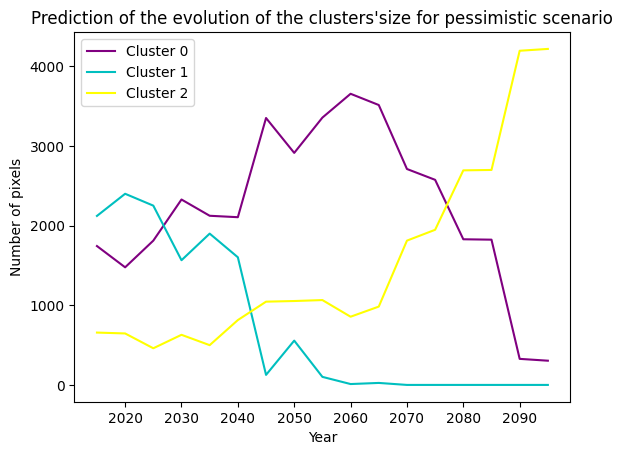

In [ ]:
years = np.arange(2015,2100,5)
colors = ['purple','c','yellow']
for k in range(3):
  plt.plot(years,compteur[k,:],label='Cluster '+str(k),c=colors[k])
  plt.xlabel('Year')
  plt.ylabel('Number of pixels')
  plt.title("Prediction of the evolution of the clusters'size for pessimistic scenario")
  plt.legend()

### For the optimistic scenario (ssp245)

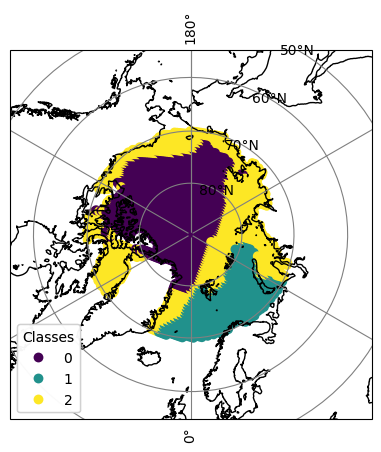

In [ ]:
# Get the data of the ssp585 scenario
X_opt_2015 = get_data(df_opt,0)

# Makes clusters
# Create the classifier:
kmeans_opt = KMeans(n_clusters=3, random_state=0, n_init=10)
# Train the classifier:
kmeans_opt.fit(X_opt_2015)
# Classify the dataset:
labels_opt_2015 = kmeans_opt.predict(X_opt_2015)

# Plot
ax = plt.axes(projection=ccrs.NorthPolarStereo());
ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
scatter = ax.scatter(X_opt_2015.nav_lon, X_opt_2015.nav_lat, c=labels_opt_2015, transform=ccrs.PlateCarree());
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
ax.coastlines();
ax.gridlines(draw_labels=True, x_inline=False, y_inline=True,color='grey');

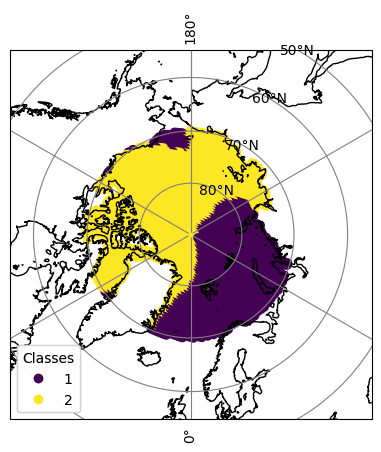

In [ ]:
# Get the data of the ssp585 scenario
X_opt_2100 = get_data(df_opt,85)
# Makes clusters
labels_opt_2100 = kmeans_opt.predict(X_opt_2100)

# Plot
ax = plt.axes(projection=ccrs.NorthPolarStereo());
ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
scatter = ax.scatter(X_opt_2100.nav_lon, X_opt_2100.nav_lat, c=labels_opt_2100, transform=ccrs.PlateCarree());
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
ax.coastlines();
ax.gridlines(draw_labels=True, x_inline=False, y_inline=True,color='grey');

In [ ]:
compteur_opt = compting_cluster(df_opt,kmeans_opt)

counting for the year 2015 done
counting for the year 2020 done
counting for the year 2025 done
counting for the year 2030 done
counting for the year 2035 done
counting for the year 2040 done
counting for the year 2045 done
counting for the year 2050 done
counting for the year 2055 done
counting for the year 2060 done
counting for the year 2065 done
counting for the year 2070 done
counting for the year 2075 done
counting for the year 2080 done
counting for the year 2085 done
counting for the year 2090 done
counting for the year 2095 done


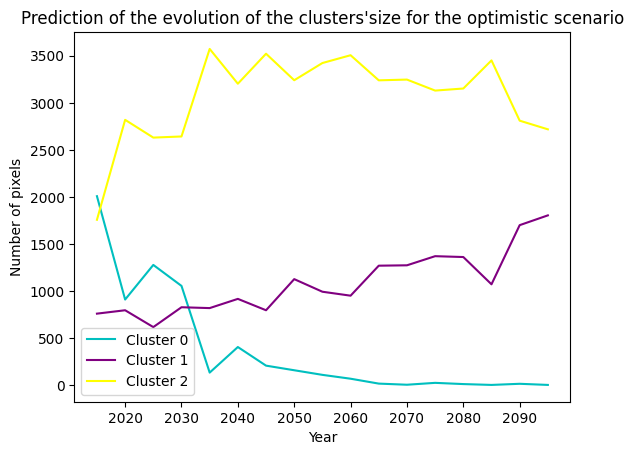

In [ ]:
years = np.arange(2015,2100,5)
colors = ['c','purple','yellow']
for k in range(3):
  plt.plot(years,compteur_opt[k,:],label='Cluster '+str(k),c=colors[k])
  plt.xlabel('Year')
  plt.ylabel('Number of pixels')
  plt.title("Prediction of the evolution of the clusters'size for the optimistic scenario")
  plt.legend()

### For the optimistic scenario (ssp245) but with a different model

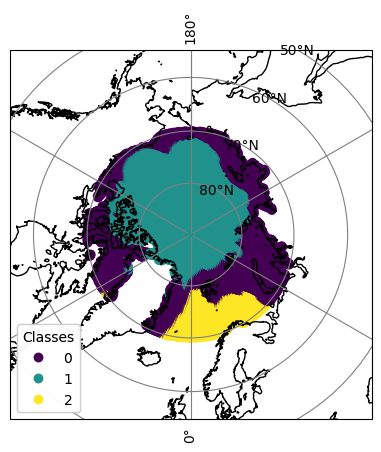

In [ ]:
# Get the data of the ssp585 scenario
X_opt_model_2015 = get_data(df_opt_model,0)

# Makes clusters
# Create the classifier:
kmeans_opt_model = KMeans(n_clusters=3, random_state=0, n_init=10)
# Train the classifier:
kmeans_opt_model.fit(X_opt_model_2015)
# Classify the dataset:
labels_opt_model_2015 = kmeans_opt_model.predict(X_opt_model_2015)

# Plot
ax = plt.axes(projection=ccrs.NorthPolarStereo());
ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
scatter = ax.scatter(X_opt_model_2015.lon, X_opt_model_2015.lat, c=labels_opt_model_2015, transform=ccrs.PlateCarree());
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
ax.coastlines();
ax.gridlines(draw_labels=True, x_inline=False, y_inline=True,color='grey');

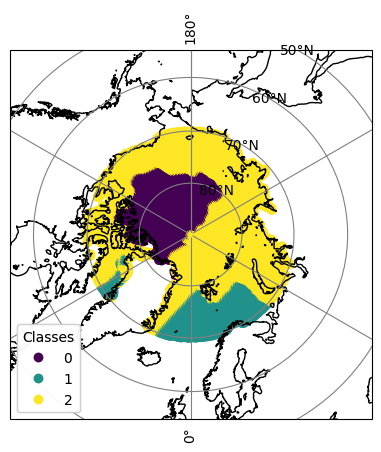

In [ ]:
# Get the data of the ssp585 scenario
X_opt_model_2100 = get_data(df_opt_model,85)
# Makes clusters
labels_opt_model_2100 = kmeans_opt.predict(X_opt_model_2100)

# Plot
ax = plt.axes(projection=ccrs.NorthPolarStereo());
ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
scatter = ax.scatter(X_opt_model_2100.lon, X_opt_model_2100.lat, c=labels_opt_model_2100, transform=ccrs.PlateCarree());
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
ax.coastlines();
ax.gridlines(draw_labels=True, x_inline=False, y_inline=True,color='grey');

In [ ]:
compteur_opt_model = compting_cluster(df_opt_model,kmeans_opt_model)

counting for the year 2015 done
counting for the year 2020 done
counting for the year 2025 done
counting for the year 2030 done
counting for the year 2035 done
counting for the year 2040 done
counting for the year 2045 done
counting for the year 2050 done
counting for the year 2055 done
counting for the year 2060 done
counting for the year 2065 done
counting for the year 2070 done
counting for the year 2075 done
counting for the year 2080 done
counting for the year 2085 done
counting for the year 2090 done
counting for the year 2095 done


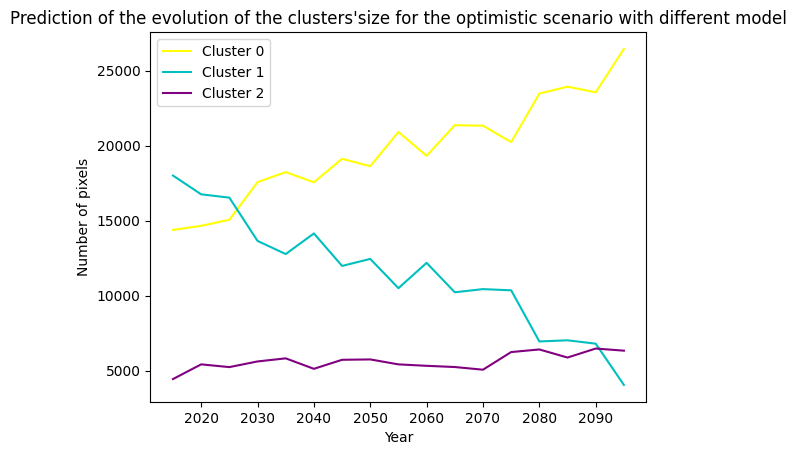

In [ ]:
years = np.arange(2015,2100,5)
colors = ['yellow','c','purple']
for k in range(3):
  plt.plot(years,compteur_opt_model[k,:],label='Cluster '+str(k),c=colors[k])
  plt.xlabel('Year')
  plt.ylabel('Number of pixels')
  plt.title("Prediction of the evolution of the clusters'size for the optimistic scenario with different model")
  plt.legend()

**Saisonnalité**

In [ ]:
winter = ds.where(ds.time.dt.season == 'DJF',drop=True)
spring=ds.where(ds.time.dt.season == 'MAM',drop=True)
summer=ds.where(ds.time.dt.season == 'JJA',drop=True)
autumn=ds.where(ds.time.dt.season == 'SON',drop=True)

In [ ]:
winter_5y= winter.resample(time='5y').mean()
spring_5y= spring.resample(time='5y').mean()
summer_5y= summer.resample(time='5y').mean()
autumn_5y= autumn.resample(time='5y').mean()

In [ ]:
ax = plt.axes(projection=ccrs.NorthPolarStereo());
ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
spring_5y.isel(time=0).siconc.plot.pcolormesh(ax=ax,transform=ccrs.PlateCarree(),x='lon', y='lat', add_colorbar=True);
ax.coastlines();
ax.gridlines(draw_labels=True, x_inline=False, y_inline=True,color='grey');

**PCA**

In [ ]:
#Implémentation du PCA :

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True,decode_times=False)
lat = ds.lat.compute()
ds=ds.where(lat > 55,drop=True)

ds_5y=ds.resample(time='5y').mean()
DS=np.asarray(ds_5y.siconc)
DS_combined = DS.reshape(DS.shape[0],(DS.shape[1]*DS.shape[2]))
DS_combined.shape
#Perform the PCA
DS_combined[np.isnan(DS_combined)] = 0 #Nan values by zero
pca = PCA(n_components=4)
#pca=PCA(n_components=None)
pca_result = pca.fit_transform(DS_combined) #valeurs temporelles des 4 composants trouvés
modes = pca.components_ # extract the first 4 modes
spatial_patterns = modes.reshape((4, DS.shape[1], DS.shape[2])) # reshape the spatial

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())

ax.coastlines()

plt.contourf(np.asarray(LON),np.asarray(LAT),spatial_patterns[0],transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,zorder=2) #on peut ajouter ,color='white par exemple
plt.colorbar()
plt.title('Spatial Pattern mode 1')
plt.xlabel('lon')
plt.ylabel('lat')
ax.gridlines(draw_labels=True, x_inline=False, y_inline=True,color='grey');

In [ ]:
plt.plot(pca_result[:, 0])
plt.title(f'Time Series mode 1')
plt.xlabel('temps')
plt.tight_layout()
plt.show()